<a href="https://colab.research.google.com/github/Deepak-Mewada/NeuroAI-NMA/blob/main/tutorials/W2D1_Macrocircuits/student/W2D1_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D1_Macrocircuits/student/W2D1_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D1_Macrocircuits/student/W2D1_Tutorial3.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 3: Neural network modularity

**Week 2, Day 1: Macrocircuits**

**By Neuromatch Academy**

__Content creators:__ Ruiyi Zhang

__Content reviewers:__ Xaq Pitkow, Hlib Solodzhuk, Patrick Mineault

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk

___

# Tutorial objectives

*Estimated timing of tutorial: 1 hour*

This tutorial will exemplify the importance of modularity in neural network architecture. We will train deep reinforcement learning (RL) agents with two types of neural network architectures, one modular and the other holistic, in a neuroscience navigation task.

As you have learned in previous lectures, better learning and generalization are important benefits of an appropriate inductive bias. This applies to both biological and artificial learning systems. Indeed, it has been shown that macaques trained in this navigation task can master the training task well and generalize to novel tasks derived from it. Since the brain is quite modular, it will be interesting to see if artificial models with a more modular architecture also allow for better learning and generalization than those with a less modular, holistic architecture.

Our learning objectives for today are:

1. Build RL agents with different neural architectures for a spatial
navigation task.
2. Compare the differences in **learning** between RL agents with different architectures.
3. Compare the differences in **generalization** between RL agents with different architectures.
4. Use neural decoding to understand why the modular architecture for this specific task is advantageous.
5. Keep the No-Free-Lunch Theorem in mind: the benefits of a modular architecture for one task cannot apply to all possible tasks.

This tutorial is based on this [paper](https://www.science.org/doi/10.1126/sciadv.adk1256).

In [3]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
link_id = "9n4fj"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/9n4fj/


---
# Setup


In [4]:
# @title Install and import feedback gadget

!pip install vibecheck datatops --quiet
!pip install pandas~=2.0.0 --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()

feedback_prefix = "W2D1_T3"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.7 MB/s eta 0:00:00


In [5]:
# @title Imports

#plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Circle

#modeling
from scipy.stats import sem
from sklearn.linear_model import LinearRegression, Ridge
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

#utils
from tqdm.notebook import tqdm
import pickle
import logging
import os
from pathlib import Path
import requests
import hashlib
import zipfile

In [6]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [7]:
# @title Helper functions

def my_tickformatter(value, pos):
    if abs(value) > 0 and abs(value) < 1:
        value = str(value).replace('0.', '.').replace('-', '\u2212')
    elif value == 0:
        value = 0
    elif int(value) == value:
        value = int(value)
    return value

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return rho, phi

def get_neural_response(agent, df):
    responses = []
    with torch.no_grad():
        for _, trial in df.iterrows():
            response = agent.actor.rnn(trial.state_input)[0]
            responses.append(response.squeeze(1))
        df['response'] = responses

def fit_decoder(trajectory, variables=['pos_x', 'pos_y'], train_frac=0.7):
    key = 'response'
    train_trajectory = trajectory[:round(len(trajectory) * train_frac)]
    train_X = np.vstack(train_trajectory[key])
    test_trajectory = trajectory[round(len(trajectory) * train_frac):]
    test_X = np.vstack(test_trajectory[key])

    y = train_trajectory[variables].values
    train_y = np.vstack([np.hstack([v for v in y[:, i]]) for i in range(y.shape[1])]).T
    y = test_trajectory[variables].values
    test_y = np.vstack([np.hstack([v for v in y[:, i]]) for i in range(y.shape[1])]).T

    decoder = Ridge(alpha=0.1)
    decoder.fit(train_X, train_y)

    return decoder, test_X, test_y

def filter_fliers(data, whis=1.5, return_idx=False):
    if not isinstance(data, list):
        data = [data]
    filtered_data = []; data_ides = []
    for value in data:
        Q1, Q2, Q3 = np.percentile(value, [25, 50, 75])
        lb = Q1 - whis * (Q3 - Q1); ub = Q3 + whis * (Q3 - Q1)
        filtered_data.append(value[(value > lb) & (value < ub)])
        data_ides.append(np.where((value > lb) & (value < ub))[0])
    if return_idx:
        return filtered_data, data_ides
    else:
        return filtered_data

In [8]:
# @title Plotting functions

major_formatter = FuncFormatter(my_tickformatter)
modular_c = 'lightseagreen'; holistic_c = 'salmon'
reward_c = 'rosybrown'; unreward_c = 'dodgerblue'

fontsize = 7
lw = 1

def set_violin_plot(vp, facecolor, edgecolor, linewidth=1, alpha=1, ls='-', hatch=r''):
    with plt.xkcd():
        plt.setp(vp['bodies'], facecolor=facecolor, edgecolor=edgecolor,
                 linewidth=linewidth, alpha=alpha ,ls=ls, hatch=hatch)
        plt.setp(vp['cmins'], facecolor=facecolor, edgecolor=edgecolor,
                 linewidth=linewidth, alpha=alpha)
        plt.setp(vp['cmaxes'], facecolor=facecolor, edgecolor=edgecolor,
                 linewidth=linewidth, alpha=alpha)
        plt.setp(vp['cbars'], facecolor='None', edgecolor='None',
                 linewidth=linewidth, alpha=alpha)

        linecolor = 'k' if facecolor == 'None' else 'snow'
        if 'cmedians' in vp:
            plt.setp(vp['cmedians'], facecolor=linecolor, edgecolor=linecolor,
                     linewidth=linewidth, alpha=alpha, ls=ls)
        if 'cmeans' in vp:
            plt.setp(vp['cmeans'], facecolor=linecolor, edgecolor=linecolor,
                     linewidth=linewidth, alpha=alpha, ls=ls)

In [9]:
# @title Set random seed

import random
import numpy as np

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(seed = 42)

In [10]:
# @title Data retrieval

def download_file(fname, url, expected_md5):
    """
    Downloads a file from the given URL and saves it locally.
    """
    if not os.path.isfile(fname):
        try:
            r = requests.get(url)
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
            return
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
            return
        if hashlib.md5(r.content).hexdigest() != expected_md5:
            print("!!! Data download appears corrupted !!!")
            return
        with open(fname, "wb") as fid:
            fid.write(r.content)

def extract_zip(zip_fname):
    """
    Extracts a ZIP file to the current directory.
    """
    with zipfile.ZipFile(zip_fname, 'r') as zip_ref:
        zip_ref.extractall(".")

# Details for the zip files to be downloaded and extracted
zip_files = [
    {
        "fname": "agents.zip",
        "url": "https://osf.io/v9xqp/download",
        "expected_md5": "2cd35da7ea34e10e6ed2e7c983f0b908"
    },
    {
        "fname": "training_curve.zip",
        "url": "https://osf.io/9kjy4/download",
        "expected_md5": "eb7e07398aa12bd0fd9cf507d9a142c6"
    }
]

# New addition for other files to be downloaded, specifically non-zip files
model_files = [
    {
        "fname": "holistic_dfs.pkl",
        "url": "https://osf.io/9h7tq/download",
        "expected_md5": "92d0adb175724641590a611c48d721cc"
    },
    {
        "fname": "holistic_dfs_2x.pkl",
        "url": "https://osf.io/ybdmp/download",
        "expected_md5": "173e13bea9c2bbe8737a40e0d36063d4"
    },
    {
        "fname": "modular_dfs.pkl",
        "url": "https://osf.io/apkym/download",
        "expected_md5": "38a4603464b3e4351bd56625d24d5e16"
    },
    {
        "fname": "modular_dfs_2x.pkl",
        "url": "https://osf.io/wqbe2/download",
        "expected_md5": "5f19bafa3308f25ca163c627b7d9f63f"
    }
]

# Process zip files: download and extract
for zip_file in zip_files:
    download_file(zip_file["fname"], zip_file["url"], zip_file["expected_md5"])
    extract_zip(zip_file["fname"])

# Process model files: download only
for model_file in model_files:
    download_file(model_file["fname"], model_file["url"], model_file["expected_md5"])

In [11]:
# @title Video 1: Introduction

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'Q9Ja6rm8xqk'), ('Bilibili', 'BV1T4421Q7gH')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [12]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_introduction")

---
# Section 1: RL agents in a spatial navigation task

We will use a naturalistic virtual navigation task to train and test RL agents. This task was previously used to investigate the neural computations underlying macaques' flexible behaviors.

## Task setup

In [13]:
# @title Video 2: Task Setup

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'lGccgy-l3ck'), ('Bilibili', 'BV14D421u7Gz')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [14]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_task_setup")

At the beginning of each trial, the subject is situated at the center of the ground plane facing forward; a target is presented at a random location within the field of view (distance: $100$ to $400$ cm, angle: $-35$ to $+35^{\circ}$) on the ground plane and disappears after $300$ ms. The subject can freely control its linear and angular velocities with a joystick (maximum: $200$ cm/s and $90^{\circ}$/s, referred to as the joystick gain) to move along its heading in the virtual environment. The objective is to navigate toward the memorized target location and then stop inside the reward zone, a circular region centered at the target location with a radius of $65$ cm. A reward is given only if the subject stops inside the reward zone (see figure below).

The subject's self-location is not directly observable because there are no stable landmarks; instead, the subject needs to use optic flow cues on the ground plane to perceive self-motion and perform path integration. Each textural element of the optic flow, an isosceles triangle, appears at random locations and orientations, disappearing after only a short lifetime, making it impossible to use as a stable landmark. A new trial starts after the subject stops moving.

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D1_Macrocircuits/static/navigation_task.png?raw=true" width="300" alt="Navigation task scheme">

**Task modeling**

In [15]:
# @title Video 3: Task Modeling

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'tVBo-h0Va3I'), ('Bilibili', 'BV1n4421Q7n3')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [16]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_task_modeling")

We formulate this task as a Partially Observable Markov Decision Process (POMDP) in discrete time, with continuous state and action spaces (see figure below). At each time step $t$, the environment is in the state $\boldsymbol{s}_t$ (including the agent's position and velocity and the target's position). The agent takes an action $\boldsymbol{a}_t$ (controlling its linear and angular velocities) to update $\boldsymbol{s}_t$ to the next state $\boldsymbol{s}_{t+1}$ following the environmental dynamics given by the transition probability $T(\boldsymbol{s}_{t+1}|\boldsymbol{s}_{t},\boldsymbol{a}_{t})$, and receives a reward $r_t$ from the environment following the reward function $R(\boldsymbol{s}_{t},\boldsymbol{a}_{t})$ ($1$ if the agent stops inside the reward zone otherwise $0$).

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D1_Macrocircuits/static/actor_critic.png?raw=true" width="300" alt="Actor-critic model">

We use a model-free **actor**-**critic** approach to learning, with the actor and critic implemented using distinct neural networks:

* *The actor*: At each $t$, the actor receives two sources of inputs $\boldsymbol{i}_{t}$ about the state: observation $\boldsymbol{o}_t$ and last action $\boldsymbol{a}_{t-1}$. It then outputs an action $\boldsymbol{a}_{t}$, aiming to maximize the state-action value $Q_t$. This value is a function of the state and action, representing the expected discounted rewards when an action is taken at a state, and future rewards are then accumulated from $t$ until the trial's last step.
* *The critic*: Since the ground truth value is unknown, the critic is used to approximate the value. In addition to receiving the same inputs as the actor to infer the state, the critic also takes as inputs the action $\boldsymbol{a}_t$ taken by the actor in this state. It then outputs the estimated $Q_t$ for this action, trained through the temporal-difference reward prediction error (TD error) after receiving the reward $r_t$ $(|r_t+\gamma Q_{t+1}-Q_{t}|$, where $\gamma$ denotes the temporal discount factor).

The state $\boldsymbol{s}_t$ is not fully observable, so the agent must maintain an internal state representation (belief $b_t$) for deciding $\boldsymbol{a}_{t}$ and $Q_t$. Both actor and critic undergo end-to-end training through back-propagation without explicit objectives for shaping $b_t$. Consequently, networks are free to learn diverse forms of $b_t$ encoded in their neural activities that aid them in achieving their learning objectives. Ideally, networks may develop an effective belief update rule, using the two sources of evidence in the inputs $\boldsymbol{i}_t=\{\boldsymbol{o}_t, \boldsymbol{a}_{t-1}\}$. They may predict the state $\boldsymbol{s}_t$ based on its internal model of the dynamics, its previous belief $b_{t-1}$, and the last self-action $\boldsymbol{a}_{t-1}$ (e.g., a motor efference copy). The second source is a partial and noisy observation $\boldsymbol{o}_t$ of $\boldsymbol{s}_t$ drawn from the observation probability $O(\boldsymbol{o}_t|\boldsymbol{s}_t)$. Note that the actual $O$ in the brain for this task is unknown. For simplicity, we model $\boldsymbol{o}_t$ as a low-dimensional vector, including the target's location when visible (the first $300$ ms, $\Delta t=0.1$ s), and the agent's observation of its velocities through optic flow, with velocities subject to Gaussian additive noise.

In [17]:
# @title Video 4: Task Parameters

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', '9fbpumGWm4A'), ('Bilibili', 'BV1Un4y197Xr')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [18]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_task_parameters")

Given this task modeling, we first specify some parameters.

In [19]:
# @title Parameters definition

class Config():
    def __init__(self):
        self.STATE_DIM = 5             # dimension of agent's state: x position, y position, heading, linear vel. v, angular vel. w
        self.ACTION_DIM = 2            # dimension of agent's action: action_v, action_w
        self.OBS_DIM = 2               # dimension of agent's observation of its movement: observation_v, observation_w
        self.TARGET_DIM = 2            # dimension of target's position: target_x, target_y

        self.TERMINAL_ACTION = 0.1     # start/stop threshold
        self.DT = 0.1                  # discretization time step
        self.EPISODE_TIME = 3.5        # max trial duration in seconds
        self.EPISODE_LEN = int(self.EPISODE_TIME / self.DT)   # max trial duration in steps

        self.LINEAR_SCALE = 400        # cm/unit
        self.goal_radius = torch.tensor([65]) / self.LINEAR_SCALE    # reward zone radius
        self.initial_radius_range = np.array([100, 400]) / self.LINEAR_SCALE   # range of target distance
        self.relative_angle_range = np.deg2rad([-35, 35])                      # range of target angle
        self.process_gain_default = torch.tensor([200 / self.LINEAR_SCALE, torch.deg2rad(torch.tensor(90.))]) # joystick gain
        self.target_offT = 3        # when target is invisible; by default target is invisible after the first 300 ms

        self.pro_noise_std_ = 0.2         # process noise std
        self.obs_noise_std_ = 0.1         # observation noise std

## Coding Exercise 1: Task environment

In [20]:
# @title Video 5: Task Environment

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'v0vSzqgxl3U'), ('Bilibili', 'BV1Mw4m1v7La')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [21]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_task_environment_video")

We then define the task environment in the following code. You can see from the code how a target is sampled for each trial. You will need to fill in the missing code to define the task dynamics $T(\boldsymbol{s}_{t+1}|\boldsymbol{s}_{t},\boldsymbol{a}_{t})$.

The code for the dynamics implements the following mathematical equations:

$$
\begin{equation}
s_{x_{t+1}}=s_{x_{t}}+s_{v_{t}} \cos (s_{\theta_t})\,\Delta t\\
\end{equation}
$$
$$
\begin{equation}
s_{y_{t+1}}=s_{y_{t}}+s_{v_{t}} \sin (s_{\theta_t})\,\Delta t\\
\end{equation}
$$
$$
\begin{equation}
s_{\theta_{t+1}}=s_{\theta_{t}}+s_{\omega_{t}}\,\Delta t \\
\end{equation}
$$
$$
\begin{equation}
s_{v_{t+1}}=G_{v}a_{v_t}  + \eta_{v_t} \\
\end{equation}
$$
$$
\begin{equation}
s_{\omega_{t+1}}=G_{\omega} a_{\omega_t}  + \eta_{\omega_t}\\
\end{equation}
$$

where the state elements include:
* x position $s_{x_{t}}$
* y position $s_{y_{t}}$
* heading $s_{\theta_{t}}$
* linear velocity $s_{v_{t}}$
* angular velocity $s_{\omega_{t}}$

$G_{v}$ and $G_{\omega}$ are the joystick gains mapping actions to linear and angular velocities. $\eta_{v_t}$ and $\eta_{\omega_t}$ are process noises.

In [22]:
class Env(nn.Module):
    def __init__(self, arg):
        """
        Initializes the environment with given arguments.

        Inputs:
        - arg (object): An object containing initialization parameters.

        Outputs:
        - None
        """
        super().__init__()
        self.__dict__.update(arg.__dict__)

    def reset(self, target_position=None, gain=None):
        """
        Resets the environment to start a new trial.

        Inputs:
        - target_position (tensor, optional): The target position for the trial. If None, a position is sampled.
        - gain (tensor, optional): The joystick gain. If None, the default gain is used.

        Outputs:
        - initial_state (tensor): The initial state of the environment.
        """
        # sample target position
        self.target_position = target_position
        if target_position is None:
            target_rel_r = torch.sqrt(torch.zeros(1).uniform_(*self.initial_radius_range**2))
            target_rel_ang = torch.zeros(1).uniform_(*self.relative_angle_range)
            rel_phi = np.pi/2 - target_rel_ang
            target_x = target_rel_r * torch.cos(rel_phi)
            target_y = target_rel_r * torch.sin(rel_phi)
            self.target_position = torch.tensor([target_x, target_y]).view([-1, 1])
        self.target_position_obs = self.target_position.clone()

        # joystick gain
        self.gain = gain
        if gain is None:
            self.gain = self.process_gain_default

        # process noise std
        self.pro_noise_std = self.gain * self.pro_noise_std_

        return torch.tensor([0, 0, np.pi / 2, 0, 0]).view([-1, 1])  # return the initial state

    def forward(self, x, a, t):
        """
        Updates the state based on the current state, action, and time.

        Inputs:
        - x (tensor): The current state of the environment.
        - a (tensor): The action taken.
        - t (int): The current time step.

        Outputs:
        - next_x (tensor): The next state of the environment.
        - reached_target (bool): Whether the target has been reached.
        """
        if t == self.target_offT:
            self.target_position_obs *= 0  # make target invisible

        relative_dist = torch.dist(x[:2], self.target_position)
        reached_target = relative_dist < self.goal_radius
        next_x = self.dynamics(x, a.view(-1))  # update state based on environment dynamics

        return next_x, reached_target

    def dynamics(self, x, a):
        """
        Defines the environment dynamics.

        Inputs:
        - x (tensor): The current state of the environment.
        - a (tensor): The action taken.

        Outputs:
        - next_x (tensor): The next state of the environment.
        """
        # sample process noise
        eta = self.pro_noise_std * torch.randn(2)

        # there are five elements in the state
        px, py, heading_angle, lin_vel, ang_vel = torch.split(x.view(-1), 1)

        # update state: s_{t+1} = f(s_{t}, a_{t})
        ###################################################################
        ## Fill out the following then remove
        #raise NotImplementedError("Student exercise: complete update for y position and angular velocity.")
        ###################################################################
        px_ = px + lin_vel * torch.cos(heading_angle) * self.DT
        # Hint: Mimic how the x position is updated. The y position update is similar,
        # but it requires the sine of 'heading_angle' instead of the cosine.
        py_ = py + lin_vel * torch.sin(heading_angle) * self.DT
        heading_angle_ = heading_angle + ang_vel * self.DT
        lin_vel_ = self.gain[0] * a[0] + eta[0]
        # Hint: The variables 'self.gain', 'a', and 'eta' are two-dimensional.
        # The first dimension is for the linear component, and the second dimension is for the angular component.
        ang_vel_ = self.gain[1] * a[1] + eta[1]
        ###################################################################
        ## End of student exercise
        ###################################################################

        next_x = torch.stack([px_, py_, heading_angle_,
                              lin_vel_.reshape(1), ang_vel_.reshape(1)]).view([-1, 1])
        return next_x

    def is_stop(self, action):
        """
        Determines if the given action is a stop action.

        Inputs:
        - action (tensor): The action.

        Outputs:
        - stop (bool): Whether the action is a stop action.
        """
        stop = (action.abs() < self.TERMINAL_ACTION).all()
        return stop

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial3_Solution_9a60cb69.py)



In [23]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_task_environment")

## Coding exercise 2: RL agent

### Agent observation

Next, we define the observation probability $O(\boldsymbol{o}_t|\boldsymbol{s}_t)$ from which the observation $\boldsymbol{o}_t$ is drawn.

The observation for self-movement is defined as

$$\boldsymbol{o}_t=H_t \boldsymbol{s}_t+\boldsymbol{\zeta}_t$$

where $\boldsymbol{\zeta}_t$ is a zero-mean Gaussian observation noise, and the observation model $H_{t}$ is a matrix that only takes the velocity elements (linear and angular velocities) from the true state, filtering out positional elements as they are unobservable. Essentially, the observation for self-movement is a noisy version of the agent's linear and angular velocities.

In [24]:
# @title Observation dynamics

class ObsStep(nn.Module):
    def __init__(self, arg):
        """
        Initializes the observation step with given arguments.

        Inputs:
        - arg (object): An object containing the parameters for state dimension, observation dimension, and observation noise standard deviation.

        Outputs:
        - None
        """
        super().__init__()
        self.STATE_DIM = arg.STATE_DIM
        self.OBS_DIM = arg.OBS_DIM
        self.obs_noise_std_ = arg.obs_noise_std_

        # observation matrix
        self.H = torch.zeros(self.OBS_DIM, self.STATE_DIM)
        self.H[0, -2] = 1
        self.H[1, -1] = 1

    def reset(self, gain):
        """
        Resets the observation noise standard deviation based on the given gain.

        Inputs:
        - gain (tensor): The gain used to scale the observation noise.

        Outputs:
        - None
        """
        self.obs_noise_std = self.obs_noise_std_ * gain

    def forward(self, x):
        """
        Computes the observation based on the current state and observation noise.

        Inputs:
        - x (tensor): The current state of the environment.

        Outputs:
        - o_t (tensor): The observed state with added noise.
        """
        zeta = (self.obs_noise_std * torch.randn(self.OBS_DIM)).view([-1, 1])
        o_t = self.H @ x + zeta
        return o_t

### Actor-critic RL agent

In [25]:
# @title Video 6: RL Agent

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', '1E-AjvSM2kw'), ('Bilibili', 'BV1ub421v7JG')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [26]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_rl_agent_video")

Each RL agent requires an actor and a critic network. Actor and critic networks can have a variety of architectures. Our goal here is to investigate whether functionally specialized modules provide advantages for our task. Therefore, we designed architectures incorporating modules with distinct levels of specialization for comparison. The first architecture is a **holistic** actor/critic, comprising a single module where all neurons jointly compute the belief $b_t$ and the action $\boldsymbol{a}_t$/value $Q_t$. In contrast, the second architecture is a **modular** actor/critic, featuring modules specialized in computing different variables (see the figure below).

The specialization of each module is determined as follows.

First, we can confine the computation of beliefs. Since computing beliefs about the evolving state requires integrating evidence over time, a network capable of computing belief must possess some form of memory. Recurrent neural networks (RNNs) satisfy this requirement by using a hidden state that evolves over time. In contrast, computations of value and action do not need additional memory when the belief is provided, making memoryless multi-layer perceptrons (MLPs) sufficient. Consequently, adopting an architecture with an RNN followed by a memoryless MLP (modular actor/critic) ensures that the computation of belief is exclusively confined to the RNN.

Second, we can confine the computation of the state-action value $Q_t$ for the critic. Since a critic is trained end-to-end to compute $Q_t$, stacking two modules between all inputs and outputs does not limit the computation of $Q_t$ to a specific module. However, since $Q_t$ is a function of the action $\boldsymbol{a}_t$, we can confine the computation of $Q_t$ to the second module of the modular critic by supplying $\boldsymbol{a}_t$ only to the second module. This ensures that the first module, lacking access to the action, cannot accurately compute $Q_t$. Therefore, the modular critic's RNN is dedicated to computing $b_t$ and sends it to the MLP dedicated to computing $Q_t$. This architecture enforces modularity.

Besides the critic, the modular actor has higher specialization than the holistic actor, which lacks confined $b_t$ computation. Thought bubbles in the figure below denote the variables that can be **computed** within each module enforced through architecture rather than indicating they are **encoded** in each module. For example, $b_t$ in modular architectures is passed to the second module, but an accurate $b_t$ computation can only be completed in the first RNN module.

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D1_Macrocircuits/static/holistic_modular.png?raw=true" width="1000" alt="Actor-critic architecture for holistic and modular representations">

We will compare two agents: the modular agent, which uses modular actor and modular critic networks, and the holistic agent, which uses holistic actor and holistic critic networks.

For simplicity, we will only present the code for actors here.

In [27]:
class Agent():
    def __init__(self, arg, Actor):
        """
        Initializes the agent with given arguments and an actor model.

        Inputs:
        - arg (object): An object containing initialization parameters such as observation dimension, action dimension, and target dimension.
        - Actor (class): The actor model class to be used by the agent.

        Outputs:
        - None
        """
        self.__dict__.update(arg.__dict__)

        self.actor = Actor(self.OBS_DIM, self.ACTION_DIM, self.TARGET_DIM)
        self.obs_step = ObsStep(arg)

    def select_action(self, state_input, hidden_in):
        """
        Selects an action based on the current state input and hidden state.

        Inputs:
        - state_input (tensor): The current state input to the actor model.
        - hidden_in (tensor): The hidden state input to the actor model.

        Outputs:
        - action (tensor): The action selected by the actor model.
        - hidden_out (tensor): The updated hidden state from the actor model.
        """
        with torch.no_grad():
            action, hidden_out = self.actor(state_input, hidden_in)
        return action, hidden_out

    def load(self, data_path, filename):
        """
        Loads the actor model parameters from a file.

        Inputs:
        - data_path (Path): The path to the directory containing the file.
        - filename (str): The name of the file to load the parameters from.

        Outputs:
        - None
        """
        self.filename = filename
        file = data_path / f'{self.filename}.tar'
        params = torch.load(file)
        self.actor.load_state_dict(params['actor_dict'])

### Holistic actor

We define the holistic actor as follows. Fill in the missing code to define the holistic architecture.

In [28]:
class HolisticActor(nn.Module):
    def __init__(self, OBS_DIM, ACTION_DIM, TARGET_DIM):
        """
        Initializes the holistic actor model with given dimensions.

        Inputs:
        - OBS_DIM (int): The dimension of the observation input.
        - ACTION_DIM (int): The dimension of the action output.
        - TARGET_DIM (int): The dimension of the target input.

        Outputs:
        - None
        """
        super().__init__()
        self.OBS_DIM = OBS_DIM
        self.ACTION_DIM = ACTION_DIM
        self.RNN_SIZE = 220  # RNN hidden size

        self.rnn = nn.LSTM(input_size=OBS_DIM + ACTION_DIM + TARGET_DIM, hidden_size=self.RNN_SIZE)
        self.l1 = nn.Linear(self.RNN_SIZE, ACTION_DIM)

    def forward(self, x, hidden_in):
        """
        Computes the action based on the current input and hidden state.

        Inputs:
        - x (tensor): The current input to the model, which includes observation, action, and target information.
        - hidden_in (tuple): The initial hidden state for the LSTM.

        Outputs:
        - a (tensor): The action output from the model.
        - hidden_out (tuple): The updated hidden state from the LSTM.
        """
        ###################################################################
        ## Fill out the following then remove
       #raise NotImplementedError("Student exercise: complete forward propagation through holistic actor.")
        ###################################################################
        #######################################################
        # TODO: Pass the input 'x' and the previous hidden state 'hidden_in' to the RNN module 'self.rnn'.
        # Get the output 'x' and the hidden state 'hidden_out' from the RNN module.
        # Refer to https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html.
        # Hint: 'self.rnn' takes two arguments as inputs and outputs two things.
        # The first position corresponds to 'x', and the second position corresponds to the hidden state.
        #######################################################
        x, hidden_out = self.rnn(x, hidden_in)

        a = torch.tanh(self.l1(x))
        return a, hidden_out

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial3_Solution_3d63fcd3.py)



In [29]:
# @title Test your implementation of `HolisticActor'!
set_seed(0)

arg = Config()
actor_test = HolisticActor(arg.OBS_DIM, arg.ACTION_DIM, arg.TARGET_DIM)

x_test = torch.randn(1, 1, 6); hidden_in_test = (torch.randn(1, 1, 220), torch.randn(1, 1, 220))
a, hidden_out = actor_test(x_test, hidden_in_test)

if torch.norm(a.reshape(-1) - torch.tensor([0.1145, -0.1694])) < 1e-2:
    print('Your function is correct!')
else:
    print('Your function is incorrect!')

Your function is correct!


### Modular actor

We define the modular actor as follows. Fill in the missing code to define the modular architecture.

In [30]:
class ModularActor(nn.Module):
    def __init__(self, OBS_DIM, ACTION_DIM, TARGET_DIM):
        """
        Initializes the modular actor model with given dimensions.

        Inputs:
        - OBS_DIM (int): The dimension of the observation input.
        - ACTION_DIM (int): The dimension of the action output.
        - TARGET_DIM (int): The dimension of the target input.

        Outputs:
        - None
        """
        super().__init__()
        self.OBS_DIM = OBS_DIM
        self.ACTION_DIM = ACTION_DIM
        self.RNN_SIZE = 128  # RNN hidden size
        MLP_SIZE = 300  # number of neurons in one MLP layer

        self.rnn = nn.LSTM(input_size=OBS_DIM + ACTION_DIM + TARGET_DIM, hidden_size=self.RNN_SIZE)
        self.l1 = nn.Linear(self.RNN_SIZE, MLP_SIZE)
        self.l2 = nn.Linear(MLP_SIZE, MLP_SIZE)
        self.l3 = nn.Linear(MLP_SIZE, ACTION_DIM)

    def forward(self, x, hidden_in):
        """
        Computes the action based on the current input and hidden state.

        Inputs:
        - x (tensor): The current input to the model, which includes observation, action, and target information.
        - hidden_in (tuple): The initial hidden state for the LSTM.

        Outputs:
        - a (tensor): The action output from the model.
        - hidden_out (tuple): The updated hidden state from the LSTM.
        """
        ###################################################################
        ## Fill out the following then remove
        #raise NotImplementedError("Student exercise: complete forward propagation through modular actor.")
        ###################################################################
        #######################################################
        # TODO: Pass 'x' to the MLP module, which consists of two linear layers with ReLU nonlinearity.
        # First, pass 'x' to the first linear layer, 'self.l1', followed by 'F.relu'.
        # Second, pass 'x' again to the second linear layer, 'self.l2', followed by 'F.relu'.
        #######################################################
        x, hidden_out = self.rnn(x, hidden_in)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))

        a = torch.tanh(self.l3(x))

        return a, hidden_out

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial3_Solution_ecb01cdf.py)



In [31]:
# @title Test your implementation of `ModularActor'!
set_seed(0)

arg = Config()
actor_test = ModularActor(arg.OBS_DIM, arg.ACTION_DIM, arg.TARGET_DIM)

x_test = torch.randn(1, 1, 6); hidden_in_test = (torch.randn(1, 1, 128), torch.randn(1, 1, 128))
a, hidden_out = actor_test(x_test, hidden_in_test)

if torch.norm(a.reshape(-1) - torch.tensor([0.0068, 0.0307])) < 1e-2:
    print('Your function is correct!')
else:
    print('Your function is incorrect!')

Your function is correct!


### Coding Exercise 2 Discussion

1. To ensure a fair comparison, the total number of trainable parameters is designed to be similar between the two architectures. How many trainable parameters are there in each architecture?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial3_Solution_16aa2d9e.py)



In [32]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_rl_agent")

---
# Section 2: Evaluate agents in the training task

Estimated timing to here from start of tutorial: 25 minutes

With the code for the environment and agents done, we will now write an evaluation function allowing the agent to interact with the environment.

## Coding Exercise 3: Evaluation function

We first sample 1000 targets for agents to steer to.

In [33]:
# @title Sample 1000 targets
arg = Config()

set_seed(0)
env = Env(arg)
target_positions = []

for _ in range(1000):
    __ = env.reset()
    target_positions.append(env.target_position)

Then, we define the evaluation function. For each target, an agent takes multiple steps to steer to it. In each step, the agent selects an action based on the input information about the state, and the environment updates according to the agent's action.

Fill in the missing code that calculates the reward.

In [34]:
def evaluation(agent, gain_factor=1):
    """
    Evaluates the agent's performance in the environment.

    Inputs:
    - agent (Agent): The agent to be evaluated.
    - gain_factor (float): A factor to scale the process gain. Default is 1.

    Outputs:
    - results (DataFrame): A DataFrame containing evaluation results with columns:
      - 'pos_x': List of x positions over episodes.
      - 'pos_y': List of y positions over episodes.
      - 'pos_r_end': List of final radial distances from origin over episodes.
      - 'target_x': List of target x positions.
      - 'target_y': List of target y positions.
      - 'target_r': List of target radial distances.
      - 'rewarded': List of binary rewards indicating if the target was reached and stopped.
      - 'state_input': List of state inputs recorded during the episodes.
    """
    set_seed(0)
    env = Env(arg)

    pos_x = []; pos_y = []; pos_r_end = []
    target_x = []; target_y = []; target_r = []
    rewarded = []; state_input_ = []

    for target_position in tqdm(target_positions):
        state = env.reset(target_position=target_position, gain=arg.process_gain_default * gain_factor)
        agent.obs_step.reset(env.gain)

        state_input = torch.cat([torch.zeros([1, 1, arg.OBS_DIM]), torch.zeros([1, 1, arg.ACTION_DIM]),
                                 env.target_position_obs.view(1, 1, -1)], dim=2)
        hidden_in = (torch.zeros(1, 1, agent.actor.RNN_SIZE), torch.zeros(1, 1, agent.actor.RNN_SIZE))

        state_inputs = []
        states = []

        for t in range(arg.EPISODE_LEN):
            # 1. Agent takes an action given the state-related input
            action, hidden_out = agent.select_action(state_input, hidden_in)

            # 2. Environment updates to the next state given state and action,
            #    as well as checking if the agent has reached the reward zone,
            #    and if the agent has stopped.
            next_state, reached_target = env(state, action, t)
            is_stop = env.is_stop(action)

            # 3. Receive reward
            ###################################################################
            ## Fill out the following then remove
            #raise NotImplementedError("Student exercise: compute the reward.")
            ###################################################################
            # TODO: Compute the reward. The reward is '1' when the target is reached and the agent stops on it,
            # otherwise, the reward is '0'.
            # Hint: Use variables 'reached_target' and 'is_stop'.
            reward = reached_target & is_stop

            # 4. Agent observes the next state and constructs the next state-related input
            next_observation = agent.obs_step(next_state)
            next_state_input = torch.cat([next_observation.view(1, 1, -1), action,
                                          env.target_position_obs.view(1, 1, -1)], dim=2)

            states.append(state)
            state_inputs.append(state_input)

            state_input = next_state_input
            state = next_state
            hidden_in = hidden_out

            # trial is done when the agent stops
            if is_stop:
                break

        # store data for each trial
        pos_x_, pos_y_, _, _, _ = torch.chunk(torch.cat(states, dim=1), state.shape[0], dim=0)
        pos_x.append(pos_x_.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_.view(-1).numpy() * arg.LINEAR_SCALE)

        pos_r, _ = cart2pol(pos_x[-1], pos_y[-1])
        pos_r_end.append(pos_r[-1])

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        target_r_, _ = cart2pol(target_x[-1], target_y[-1])
        target_r.append(target_r_)

        state_input_.append(torch.cat(state_inputs))
        rewarded.append(reward.item())

    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y,
                                 pos_r_end=pos_r_end, target_x=target_x, target_y=target_y,
                                 target_r=target_r, rewarded=rewarded,
                                 state_input=state_input_))

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial3_Solution_4fb20840.py)



Since training RL agents takes a lot of time, here we load the pre-trained modular and holistic agents and evaluate these two agents on the same sampled 1000 targets. We will then store the evaluation data in pandas dataframes.

In [35]:
modular_agent = Agent(arg, ModularActor)
modular_agent.load(Path('agents/modular'), 0)
modular_df = evaluation(modular_agent)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
holistic_agent = Agent(arg, HolisticActor)
holistic_agent.load(Path('agents/holistic'), 0)
holistic_df = evaluation(holistic_agent)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [37]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_evaluation_function")

## Coding Exercise 4: Agent trajectory in a single trial

After evaluation, we want to visualize the agents' steering trajectories. Fill in the missing code to compute the distance between the stop location and the target location. Given the reward boundary is $65$ cm, are these trials rewarded?

### Modular agent trajectory

Target distance from the start location: 312.6 cm
Target distance from the stop location: 32.4 cm
Steps taken: 15


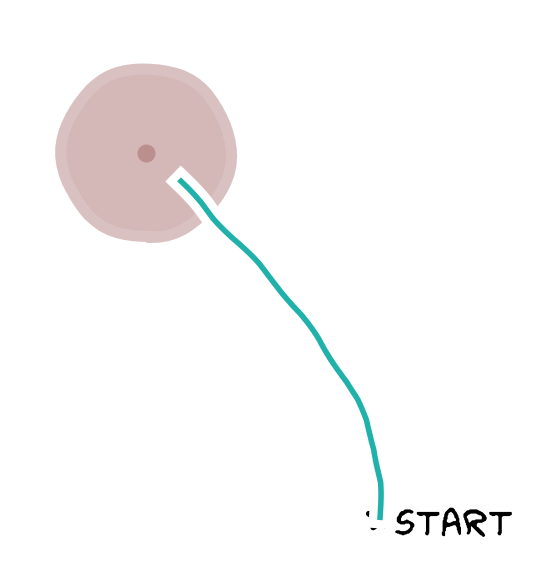

In [38]:
with plt.xkcd():
    trial_idx = 21
    trial = modular_df.iloc[trial_idx]

    fig = plt.figure(figsize=(2.2, 1.7), dpi=200)
    ax = fig.add_subplot(111)

    ax.set_aspect('equal')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])

    # plot trajectory
    px = trial.pos_x; py = trial.pos_y
    ax.plot(px, py, lw=lw, c=modular_c)

    # plot target
    target_x = trial.target_x; target_y = trial.target_y
    print(f'Target distance from the start location: {np.around(trial.target_r, 1)} cm')

    ###################################################################
    ## Fill out the following then remove
    #raise NotImplementedError("Student exercise: calculate the distance between target location and stop position.")
    ###################################################################
    # Given target locations as trial.target_x and trial.target_y,
    # and stop locations as trial.pos_x[-1] and trial.pos_y[-1],
    # compute the Euclidean distance between the target and stop locations.
    distance_stoploc_to_target = np.sqrt((trial.target_x - trial.pos_x[-1])**2
                                         + (trial.target_y - trial.pos_y[-1])**2)
    print(f'Target distance from the stop location: {np.around(distance_stoploc_to_target, 1)} cm')

    print(f'Steps taken: {px.size - 1}')

    reward_boundary_radius = arg.goal_radius * arg.LINEAR_SCALE
    target_color = reward_c if distance_stoploc_to_target < reward_boundary_radius else unreward_c

    cir1 = Circle(xy=[target_x, target_y], radius=reward_boundary_radius, alpha=0.4, color=target_color, lw=0)
    ax.add_patch(cir1)
    ax.scatter(target_x, target_y, c=target_color, s=5)

    # plot initial position
    ax.scatter(0, 0, c='k', s=20, marker='*')
    ax.text(10, -10, s='Start', fontsize=fontsize)

    fig.tight_layout(pad=0)

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial3_Solution_3f3de125.py)

*Example output:*

<img alt='Solution hint' align='left' width=131.0 height=152.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D1_Macrocircuits/static/W2D1_Tutorial3_Solution_3f3de125_1.png>



### Holistic agent trajectory

Target distance from the start location: 312.6 cm
Target distance from the stop location: 31.5 cm
Steps taken: 18


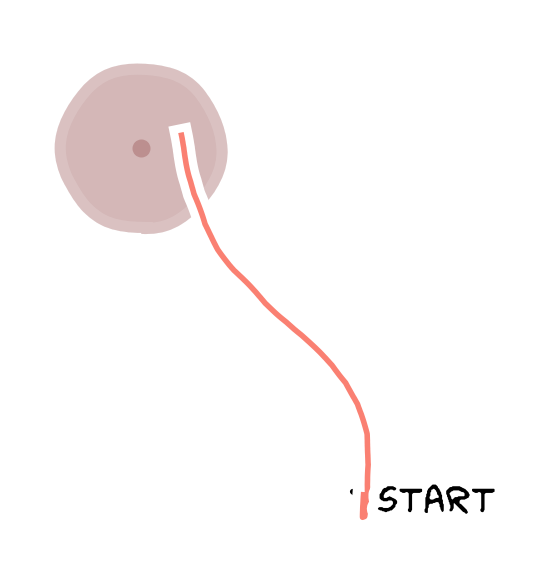

In [39]:
# @title Holistic agent trajectory

with plt.xkcd():
    trial_idx = 21
    trial = holistic_df.iloc[trial_idx]

    fig = plt.figure(figsize=(2.2, 1.7), dpi=200)
    ax = fig.add_subplot(111)

    ax.set_aspect('equal')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])

    # plot trajectory
    px = trial.pos_x; py = trial.pos_y
    ax.plot(px, py, lw=lw, c=holistic_c)

    # plot target
    target_x = trial.target_x; target_y = trial.target_y
    print(f'Target distance from the start location: {np.around(trial.target_r, 1)} cm')

    distance_stoploc_to_target = np.sqrt((trial.target_x - trial.pos_x[-1])**2
                                         + (trial.target_y - trial.pos_y[-1])**2)
    print(f'Target distance from the stop location: {np.around(distance_stoploc_to_target, 1)} cm')

    print(f'Steps taken: {px.size - 1}')

    reward_boundary_radius = arg.goal_radius * arg.LINEAR_SCALE
    target_color = reward_c if distance_stoploc_to_target < reward_boundary_radius else unreward_c

    cir1 = Circle(xy=[target_x, target_y], radius=reward_boundary_radius, alpha=0.4, color=target_color, lw=0)
    ax.add_patch(cir1)
    ax.scatter(target_x, target_y, c=target_color, s=5)

    # plot initial position
    ax.scatter(0, 0, c='k', s=20, marker='*')
    ax.text(10, -10, s='Start', fontsize=fontsize)

    fig.tight_layout(pad=0)

### Coding Exercise 4 Discussion

1. Is there any difference between the trajectories for the modular and holistic agents? If so, what does it imply?

In [40]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_agent_trajectory_in_a_single_trial")

## Activity: Comparing performance of agents

### Agent trajectories across trials

We can also visualize multiple trials together. Here, we visualize trajectories steering towards $500$ targets.

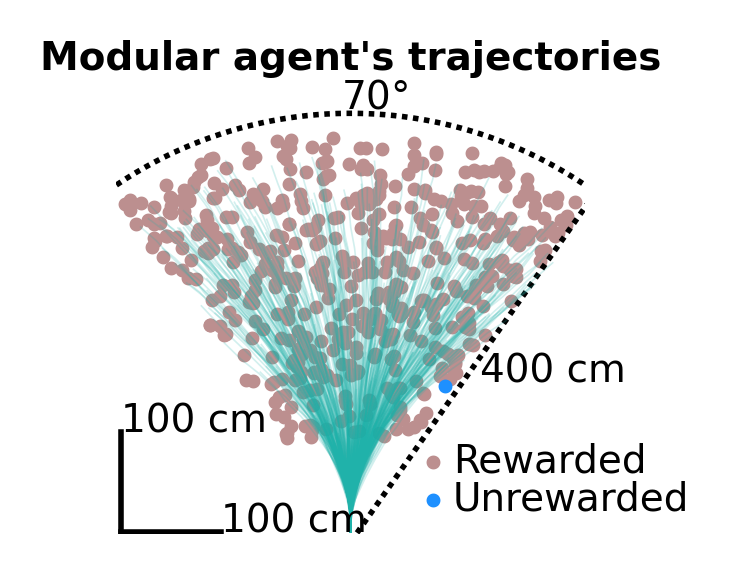

In [41]:
# @title Modular agent's trajectories

target_idexes = np.arange(0, 500)
df = modular_df

fig = plt.figure(figsize=(2.2, 1.7), dpi=200)
ax = fig.add_subplot(111)
ax.set_title("Modular agent's trajectories", fontsize=fontsize, fontweight='bold')
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])
ax.set_xlim([-235, 235]); ax.set_ylim([-2, 430])

ax.plot(np.linspace(0, 230 + 7), np.tan(np.deg2rad(55)) * np.linspace(0, 230 + 7) - 10,
        c='k', ls=(0, (1, 1)), lw=lw)
for _, trial in df.iloc[target_idexes].iterrows():
    ax.plot(trial.pos_x, trial.pos_y, c=modular_c, lw=0.3, ls='-', alpha=0.2)

reward_idexes = df.rewarded.iloc[target_idexes].values
for label, mask, c in zip(['Rewarded', 'Unrewarded'], [reward_idexes, ~reward_idexes],
                          [reward_c, unreward_c]):
    ax.scatter(*df.iloc[target_idexes].loc[mask, ['target_x', 'target_y']].values.T,
               c=c, marker='o', s=1, lw=1.5, label=label)

x_temp = np.linspace(-235, 235)
ax.plot(x_temp, np.sqrt(420**2 - x_temp**2), c='k', ls=(0, (1, 1)), lw=lw)
ax.text(-10, 425, s=r'70$\degree$', fontsize=fontsize)
ax.text(130, 150, s=r'400 cm', fontsize=fontsize)

ax.plot(np.linspace(-230, -130), np.linspace(0, 0), c='k', lw=lw)
ax.plot(np.linspace(-230, -230), np.linspace(0, 100), c='k', lw=lw)
ax.text(-230, 100, s=r'100 cm', fontsize=fontsize)
ax.text(-130, 0, s=r'100 cm', fontsize=fontsize)

ax.legend(fontsize=fontsize, frameon=False, loc=[0.56, 0.0],
          handletextpad=-0.5, labelspacing=0, ncol=1, columnspacing=1)

fig.tight_layout(pad=0)

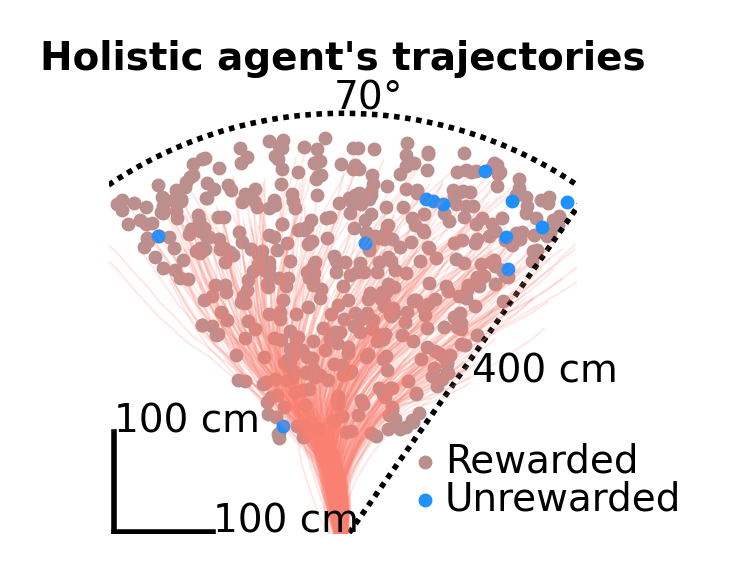

In [42]:
# @title Holistic agent's trajectories

target_idexes = np.arange(0, 500)
df = holistic_df

fig = plt.figure(figsize=(2.2, 1.7), dpi=200)
ax = fig.add_subplot(111)
ax.set_title("Holistic agent's trajectories", fontsize=fontsize, fontweight='bold')
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])
ax.set_xlim([-235, 235]); ax.set_ylim([-2, 430])

ax.plot(np.linspace(0, 230 + 7), np.tan(np.deg2rad(55)) * np.linspace(0, 230 + 7) - 10,
        c='k', ls=(0, (1, 1)), lw=lw)
for _, trial in df.iloc[target_idexes].iterrows():
    ax.plot(trial.pos_x, trial.pos_y, c=holistic_c, lw=0.3, ls='-', alpha=0.2)

reward_idexes = df.rewarded.iloc[target_idexes].values
for label, mask, c in zip(['Rewarded', 'Unrewarded'], [reward_idexes, ~reward_idexes],
                          [reward_c, unreward_c]):
    ax.scatter(*df.iloc[target_idexes].loc[mask, ['target_x', 'target_y']].values.T,
               c=c, marker='o', s=1, lw=1.5, label=label)

x_temp = np.linspace(-235, 235)
ax.plot(x_temp, np.sqrt(420**2 - x_temp**2), c='k', ls=(0, (1, 1)), lw=lw)
ax.text(-10, 425, s=r'70$\degree$', fontsize=fontsize)
ax.text(130, 150, s=r'400 cm', fontsize=fontsize)

ax.plot(np.linspace(-230, -130), np.linspace(0, 0), c='k', lw=lw)
ax.plot(np.linspace(-230, -230), np.linspace(0, 100), c='k', lw=lw)
ax.text(-230, 100, s=r'100 cm', fontsize=fontsize)
ax.text(-130, 0, s=r'100 cm', fontsize=fontsize)

ax.legend(fontsize=fontsize, frameon=False, loc=[0.56, 0.0],
          handletextpad=-0.5, labelspacing=0, ncol=1, columnspacing=1)

fig.tight_layout(pad=0)

### Discussion

1. Is there any difference between the two agents' trajectories?

### Agents trained with multiple random seeds

It is well known that an RL agent's performance can vary significantly with different random seeds. Therefore, no conclusions can be drawn based on one training run with a single random seed.

Both agents were trained with eight random seeds, and all of them were evaluated using the same sample of $1000$ targets. Let's load this saved trajectory data.

In [43]:
# @title Load agents
with open('modular_dfs.pkl', 'rb') as file:
    modular_dfs = pickle.load(file)

with open('holistic_dfs.pkl', 'rb') as file:
    holistic_dfs = pickle.load(file)

### Reward fraction comparison

We first compute the fraction of rewarded trials in the total $1000$ trials for all training runs with different random seeds for the modular and holistic agents. We visualize this using a bar plot, with each red dot denoting the performance of a random seed.

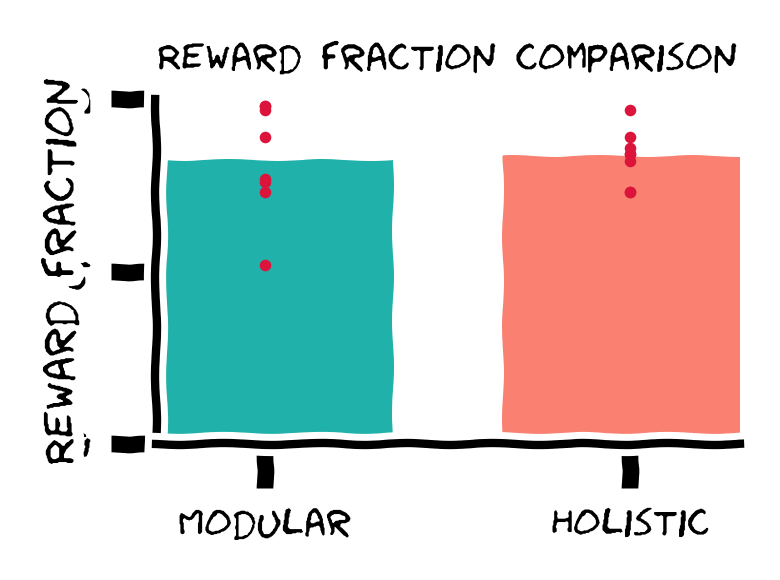

In [44]:
# @title Reward function comparison

with plt.xkcd():
    xticks = [0, 1]; xticklabels = ['Modular', 'Holistic']
    yticks = [0.9, 0.95, 1]

    fig = plt.figure(figsize=(2.2, 1.7), dpi=200)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Reward fraction comparison', fontsize=fontsize, fontweight='bold')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'', fontsize=fontsize + 1)
    ax.set_ylabel('Reward fraction', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0] - 0.3, xticks[-1] + 0.3)
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.15)
    ax.yaxis.set_label_coords(-0.13, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    for (idx, dfs), c in zip(enumerate([modular_dfs, holistic_dfs]), [modular_c, holistic_c]):
        ydata = [df.rewarded.sum() / len(df) for df in dfs]
        ax.bar(idx, np.mean(ydata), width=0.7, color=c, alpha=1, zorder=0)
        ax.scatter([idx] * len(ydata), ydata, c='crimson', marker='.',
                   s=10, lw=0.5, zorder=1, clip_on=False)

    fig.tight_layout(pad=0.1, rect=(0, 0, 1, 1))

### Time spent comparison

Despite similar performance measured by a rewarded fraction, we dis observe qualitative differences in the trajectories of the two agents in the previous sections. It is possible that the holistic agent's more curved trajectories, although reaching the target, are less efficient, i.e., they waste more time.

Therefore, we also plot the time spent by both agents for the same 1000 targets.

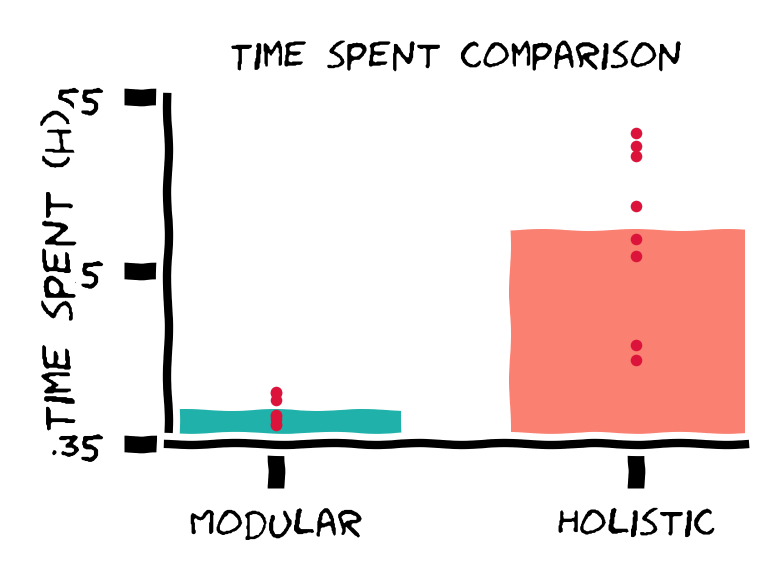

In [45]:
# @title Time spent comparison

with plt.xkcd():
    xticks = [0, 1]; xticklabels = ['Modular', 'Holistic']
    yticks = [0.35, 0.45, 0.55]

    fig = plt.figure(figsize=(2.2, 1.7), dpi=200)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Time spent comparison', fontsize=fontsize, fontweight='bold')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'', fontsize=fontsize + 1)
    ax.set_ylabel('Time spent (h)', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0] - 0.3, xticks[-1] + 0.3)
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.15)
    ax.yaxis.set_label_coords(-0.16, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    for (idx, dfs), c in zip(enumerate([modular_dfs, holistic_dfs]), [modular_c, holistic_c]):
        ydata = [(np.hstack(df.pos_x).size - len(df)) * arg.DT / 3600 for df in dfs]
        ax.bar(idx, np.mean(ydata), width=0.7, color=c, alpha=1, zorder=0)
        ax.scatter([idx] * len(ydata), ydata, c='crimson', marker='.',
                   s=10, lw=0.5, zorder=1, clip_on=False)

    fig.tight_layout(pad=0.1, rect=(0, 0, 1, 1))

### Discussion
1. Which agent's behavior is more desired in the RL framework? Why?

*Hint*: Consider the objective functions for the critic and actor. The discount factor $\gamma$ used in training is smaller than $1$.

### Training curve

So far, we have only tested the agents after training. We can also visualize the performance curve for both agents during the training course.

During training, for every $500$ training trials, the agent's performance (fraction of rewarded trials) was evaluated. These data were saved; we'll load them back in for visualization.

In [46]:
# @title Load training curves

training_curve_path = Path('training_curve')
holistic_curves = [pd.read_csv(file) for file in training_curve_path.glob(f'holistic*')]
modular_curves = [pd.read_csv(file) for file in training_curve_path.glob(f'modular*')]

Let us plot the training curves for both agents. The shaded area denotes the standard error of the mean across all random seeds.

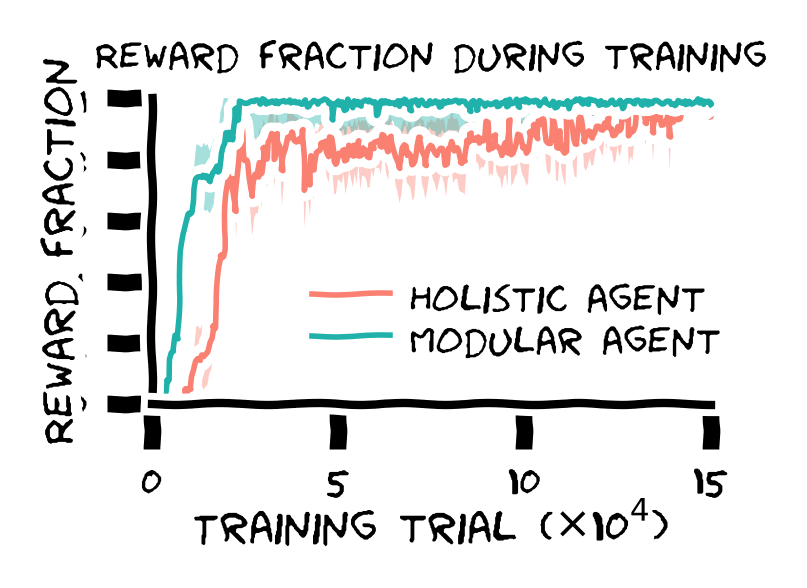

In [47]:
# @title Visualize training curves

mean_holistic_curves = np.vstack([v.reward_fraction for v in holistic_curves]).mean(axis=0)
sem_holistic_curves = sem(np.vstack([v.reward_fraction for v in holistic_curves]), axis=0)
mean_modular_curves = np.vstack([v.reward_fraction for v in modular_curves]).mean(axis=0)
sem_modular_curves = sem(np.vstack([v.reward_fraction for v in holistic_curves]), axis=0)

xaxis_scale = int(1e4)
yticks = np.around(np.linspace(0, 1, 6), 1)
xticks = np.around(np.linspace(0, 1.5e5, 4), 1)
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]

with plt.xkcd():
    fig = plt.figure(figsize=(2.2, 1.7), dpi=200)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Reward fraction during training', fontsize=fontsize, fontweight='bold')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'Training trial ($\times$10$^4$)', fontsize=fontsize + 1)
    ax.set_ylabel('Reward fraction', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.3)
    ax.yaxis.set_label_coords(-0.13, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    xdata = holistic_curves[0].episode.values
    for ymean, ysem, color, label in zip([mean_holistic_curves, mean_modular_curves],
                                         [sem_holistic_curves, sem_modular_curves],
                                         [holistic_c, modular_c],
                                         ['Holistic agent', 'Modular agent']):
        ax.plot(xdata, ymean, lw=lw, clip_on=False, c=color, label=label)
        ax.fill_between(xdata, ymean - ysem, ymean + ysem, edgecolor='None',
                        facecolor=color, alpha=0.4, clip_on=True)

    ax.legend(fontsize=fontsize, frameon=False, loc=[0.26, 0.1],
              handletextpad=0.5, labelspacing=0.2, ncol=1, columnspacing=1)

    fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))

**Conclusion for the training task:** The modular agent learned faster and developed more efficient behaviors than the holistic agent.

In [48]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_comparing_performance_of_agents")

---
# Section 3: A novel gain task

Estimated timing to here from start of tutorial: 50 minutes

In [49]:
# @title Video 7: Novel Task

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'wpfvgl1q9zg'), ('Bilibili', 'BV1Wb421v7Gi')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [50]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_novel_task_video")

A good architecture should not only learn fast but also generalize better.

One crucial parameter in our task is the joystick gain, which linearly maps motor actions (dimensionless, bounded in $[-1,1]$) to corresponding velocities in the environment, i.e., velocity=gain $\cdot$ action (see the environment dynamics above). During training, the gain remains fixed at $200$ cm/s and $90^{\circ}$/s for linear and angular components, referred to as the $1\times$ gain.

To test agents' generalization abilities, here, we increase the gain to $2\times$. This means the maximum velocities in the environment are doubled to $400$ cm/s and $180^{\circ}$/s. Note that agents were only exposed to the $1\times$ gain during training. Therefore, if they use the same sequence of actions as in training with the $2\times$ gain, they will overshoot targets.

Let us evaluate modular and holistic agents with the same $1000$ sampled targets again, but now with the $2\times$ gain.

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D1_Macrocircuits/static/gain_change.png?raw=true" width="300" alt="Change in gain">

In [51]:
gain_factor = 2

In [52]:
# @title Load holistic & modular agents
modular_agent = Agent(arg, ModularActor)
modular_agent.load(Path('agents/modular'), 0)
modular_dfs_2x = evaluation(modular_agent, gain_factor=gain_factor)

holistic_agent = Agent(arg, HolisticActor)
holistic_agent.load(Path('agents/holistic'), 0)
holistic_dfs_2x = evaluation(holistic_agent, gain_factor=gain_factor)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Let us first visualize the modular agents' trajectories with $2\times$ gain.

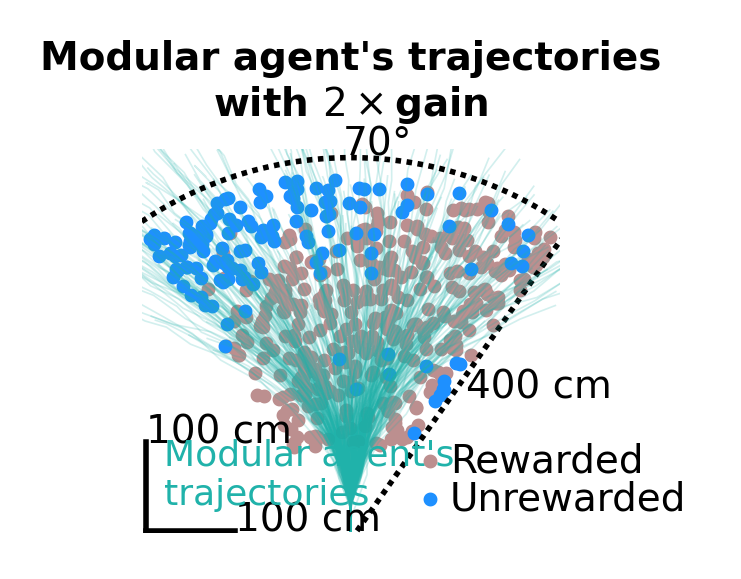

In [53]:
# @title Modular agent's trajectories

target_idexes = np.arange(0, 500)
df = modular_dfs_2x

fig = plt.figure(figsize=(2.2, 1.7), dpi=200)
ax = fig.add_subplot(111)
ax.set_title("Modular agent's trajectories\nwith " +
             r'$2\times$gain', fontsize=fontsize, fontweight='bold')
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])
ax.set_xlim([-235, 235]); ax.set_ylim([-2, 430])

ax.plot(np.linspace(0, 230 + 7), np.tan(np.deg2rad(55)) * np.linspace(0, 230 + 7) - 10,
        c='k', ls=(0, (1, 1)), lw=lw)
for _, trial in df.iloc[target_idexes].iterrows():
    ax.plot(trial.pos_x, trial.pos_y, c=modular_c, lw=0.3, ls='-', alpha=0.2)

reward_idexes = df.rewarded.iloc[target_idexes].values
for label, mask, c in zip(['Rewarded', 'Unrewarded'], [reward_idexes, ~reward_idexes],
                          [reward_c, unreward_c]):
    ax.scatter(*df.iloc[target_idexes].loc[mask, ['target_x', 'target_y']].values.T,
               c=c, marker='o', s=1, lw=1.5, label=label)

x_temp = np.linspace(-235, 235)
ax.plot(x_temp, np.sqrt(420**2 - x_temp**2), c='k', ls=(0, (1, 1)), lw=lw)
ax.text(-10, 425, s=r'70$\degree$', fontsize=fontsize)
ax.text(130, 150, s=r'400 cm', fontsize=fontsize)

ax.plot(np.linspace(-230, -130), np.linspace(0, 0), c='k', lw=lw)
ax.plot(np.linspace(-230, -230), np.linspace(0, 100), c='k', lw=lw)
ax.text(-230, 100, s=r'100 cm', fontsize=fontsize)
ax.text(-130, 0, s=r'100 cm', fontsize=fontsize)

ax.text(-210, 30, s="Modular agent's\ntrajectories", fontsize=fontsize - 0.5, c=modular_c)

ax.legend(fontsize=fontsize, frameon=False, loc=[0.56, 0.0],
          handletextpad=-0.5, labelspacing=0, ncol=1, columnspacing=1)

fig.tight_layout(pad=0)

Let us now visualize the holistic agents' trajectories with $2\times$ gain.

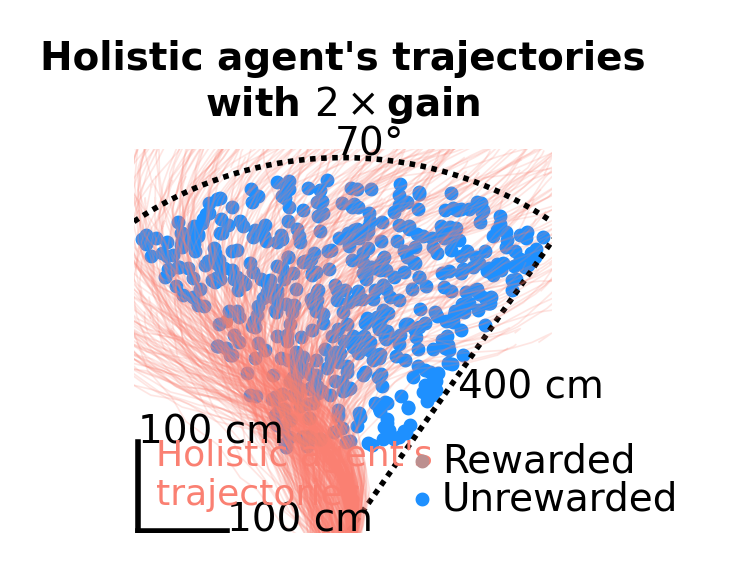

In [54]:
# @title Holistic agent's trajectories

target_idexes = np.arange(0, 500)
df = holistic_dfs_2x

fig = plt.figure(figsize=(2.2, 1.7), dpi=200)
ax = fig.add_subplot(111)
ax.set_title("Holistic agent's trajectories\nwith " +
             r'$2\times$gain', fontsize=fontsize, fontweight='bold')
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])
ax.set_xlim([-235, 235]); ax.set_ylim([-2, 430])

ax.plot(np.linspace(0, 230 + 7), np.tan(np.deg2rad(55)) * np.linspace(0, 230 + 7) - 10,
        c='k', ls=(0, (1, 1)), lw=lw)
for _, trial in df.iloc[target_idexes].iterrows():
    ax.plot(trial.pos_x, trial.pos_y, c=holistic_c, lw=0.3, ls='-', alpha=0.2)

reward_idexes = df.rewarded.iloc[target_idexes].values
for label, mask, c in zip(['Rewarded', 'Unrewarded'], [reward_idexes, ~reward_idexes],
                          [reward_c, unreward_c]):
    ax.scatter(*df.iloc[target_idexes].loc[mask, ['target_x', 'target_y']].values.T,
               c=c, marker='o', s=1, lw=1.5, label=label)


x_temp = np.linspace(-235, 235)
ax.plot(x_temp, np.sqrt(420**2 - x_temp**2), c='k', ls=(0, (1, 1)), lw=lw)
ax.text(-10, 425, s=r'70$\degree$', fontsize=fontsize)
ax.text(130, 150, s=r'400 cm', fontsize=fontsize)

ax.plot(np.linspace(-230, -130), np.linspace(0, 0), c='k', lw=lw)
ax.plot(np.linspace(-230, -230), np.linspace(0, 100), c='k', lw=lw)
ax.text(-230, 100, s=r'100 cm', fontsize=fontsize)
ax.text(-130, 0, s=r'100 cm', fontsize=fontsize)

ax.text(-210, 30, s="Holistic agent's\ntrajectories", fontsize=fontsize - 0.5, c=holistic_c)

ax.legend(fontsize=fontsize, frameon=False, loc=[0.56, 0.0],
          handletextpad=-0.5, labelspacing=0, ncol=1, columnspacing=1)

fig.tight_layout(pad=0)

### Discussion

1. Do the two agents have the same generalization abilities?

Again, let us load the saved evaluation data with the $2\times$ gain for agents with all $8$ random seeds.

In [55]:
# @title Load data
with open('modular_dfs_2x.pkl', 'rb') as file:
    modular_dfs_2x = pickle.load(file)

with open('holistic_dfs_2x.pkl', 'rb') as file:
    holistic_dfs_2x = pickle.load(file)

Now, let's compare reward fraction with $2\times$ gain.

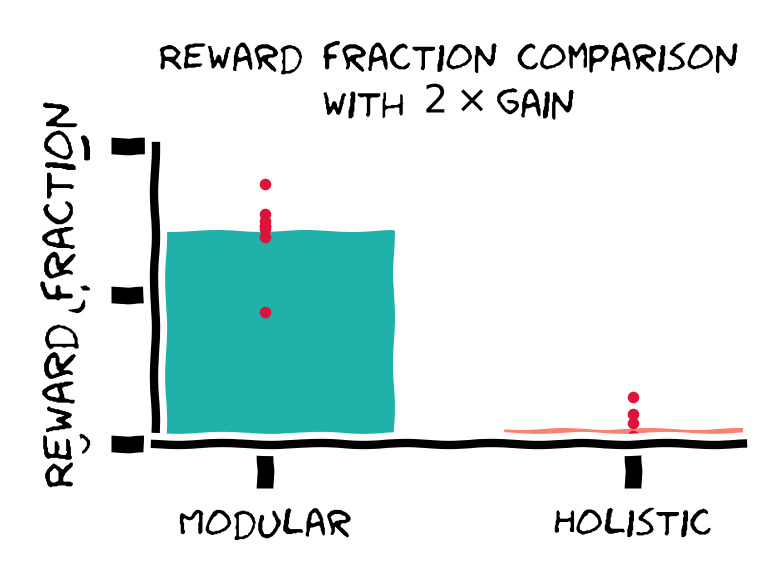

In [56]:
# @title Reward function comparison

with plt.xkcd():
    xticks = [0, 1]; xticklabels = ['Modular', 'Holistic']
    yticks = [0, 0.5, 1]

    fig = plt.figure(figsize=(2.2, 1.7), dpi=200)
    ax = fig.add_subplot(111)
    ax.set_title("Reward fraction comparison\nwith " +
                 r'$2\times$gain', fontsize=fontsize, fontweight='bold')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'', fontsize=fontsize + 1)
    ax.set_ylabel('Reward fraction', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0] - 0.3, xticks[-1] + 0.3)
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.15)
    ax.yaxis.set_label_coords(-0.13, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    for (idx, dfs), c in zip(enumerate([modular_dfs_2x, holistic_dfs_2x]), [modular_c, holistic_c]):
        ydata = [df.rewarded.sum() / len(df) for df in dfs]
        ax.bar(idx, np.mean(ydata), width=0.7, color=c, alpha=1, zorder=0)
        ax.scatter([idx] * len(ydata), ydata, c='crimson', marker='.',
                   s=10, lw=0.5, zorder=1, clip_on=False)

    fig.tight_layout(pad=0.1, rect=(0, 0, 1, 1))

Let us also compare traveled distance vs target distance with $2\times$ gain for different agents.

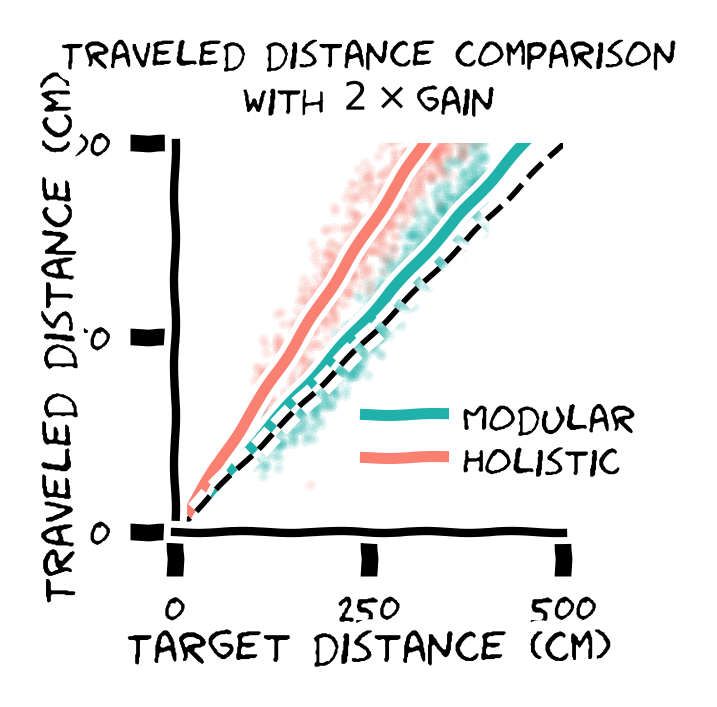

In [57]:
# @title Traveled distance comparison
with plt.xkcd():
    xticks = np.array([0, 250, 500])
    yticks = xticks

    fig = plt.figure(figsize=(2, 2), dpi=200)
    ax = fig.add_subplot(111)
    ax.set_title("Traveled distance comparison\nwith " +
                 r'$2\times$gain', fontsize=fontsize, fontweight='bold')
    ax.set_aspect('equal')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel('Target distance (cm)', fontsize=fontsize + 1)
    ax.set_ylabel('Traveled distance (cm)', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.25)
    ax.yaxis.set_label_coords(-0.25, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    xdata_m = np.hstack([df.target_r for df in modular_dfs_2x])
    ydata_m = np.hstack([df.pos_r_end for df in modular_dfs_2x])
    xdata_h = np.hstack([df.target_r for df in holistic_dfs_2x])
    ydata_h = np.hstack([df.pos_r_end for df in holistic_dfs_2x])

    sampled_trial_idx = np.random.choice(np.arange(ydata_m.size), size=1000, replace=False)

    ax.scatter(xdata_m[sampled_trial_idx], ydata_m[sampled_trial_idx], c=modular_c, s=1, alpha=0.1)
    ax.scatter(xdata_h[sampled_trial_idx], ydata_h[sampled_trial_idx], c=holistic_c, s=1, alpha=0.1)

    model = LinearRegression(fit_intercept=False)
    model.fit(xdata_m.reshape(-1, 1), ydata_m)
    ax.plot(xticks, model.predict(xticks.reshape(-1, 1)), c=modular_c,
            ls='-', lw=lw*2, label='Modular')

    model = LinearRegression(fit_intercept=False)
    model.fit(xdata_h.reshape(-1, 1), ydata_h)
    ax.plot(xticks, model.predict(xticks.reshape(-1, 1)), c=holistic_c,
            ls='-', lw=lw*2, label='Holistic')

    ax.plot(xticks, yticks, c='k', ls='--', lw=lw)

    ax.legend(fontsize=fontsize, frameon=False, loc=[0.45, 0.1],
              handletextpad=0.5, labelspacing=0.2, ncol=1, columnspacing=1)

    fig.tight_layout(pad=0.1, rect=(0, 0, 1, 1))

### Discussion:
1. What have you found? Which agent generalized better?

In [58]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_novel_gain_task")

---
# Summary

*Estimated timing of tutorial: 1 hour*

In this tutorial, we explored the difference in agents' performance based on their architecture. We revealed that modular architecture, with separate modules for learning different aspects of behavior, is superior to a holistic architecture with a single module. The modular architecture with stronger inductive bias achieves good performance faster and has the capability to generalize to other tasks as well. Intriguingly, this modularity is a property we also observe in the brains, which could be important for generalization in the brain as well.

---
# Bonus Section 1: Decoding analysis

Although we have confirmed that the modular agent exhibited better generalization performance in the gain task, the underlying mechanism remains unclear. One reasonable hypothesis is that the modular agent has a robust belief that remains accurate with the $2\times$ gain. Therefore, this robust belief can support good actions. Ultimately, agents should be aware of its location to avoid overshooting.

To test this hypothesis, we recorded the activities of RNN neurons in the agents' actors, as these neurons are responsible for computing the beliefs underlying actions. Since beliefs should represent the agents' locations in the environment, we used linear regression (with $\ell_2$ regularization) to decode agents' locations from the recorded RNN activities.

We defined the decoding error, representing the Euclidean distance between the true and decoded locations, as an indicator of belief accuracy.

In [59]:
# @title Load data
modular_decoder_data = [fit_decoder(df) for df in modular_dfs]
modular_decoder_data_2x = [fit_decoder(df) for df in modular_dfs_2x]
modular_decoding_error = np.hstack([np.linalg.norm(v[2] - v[0].predict(v[1]), axis=1) for v
                                    in modular_decoder_data])
modular_decoding_error_2x = np.hstack([np.linalg.norm(v[2] - v[0].predict(v[1]), axis=1) for v
                                       in modular_decoder_data_2x])

holistic_decoder_data = [fit_decoder(df) for df in holistic_dfs]
holistic_decoder_data_2x = [fit_decoder(df) for df in holistic_dfs_2x]
holistic_decoding_error = np.hstack([np.linalg.norm(v[2] - v[0].predict(v[1]), axis=1) for v
                                     in holistic_decoder_data])
holistic_decoding_error_2x = np.hstack([np.linalg.norm(v[2] - v[0].predict(v[1]), axis=1) for v
                                        in holistic_decoder_data_2x])

We plot the distribution of the decoding error for every step in every trial across random seeds for each agent, under $1×$ or $2×$ gain.

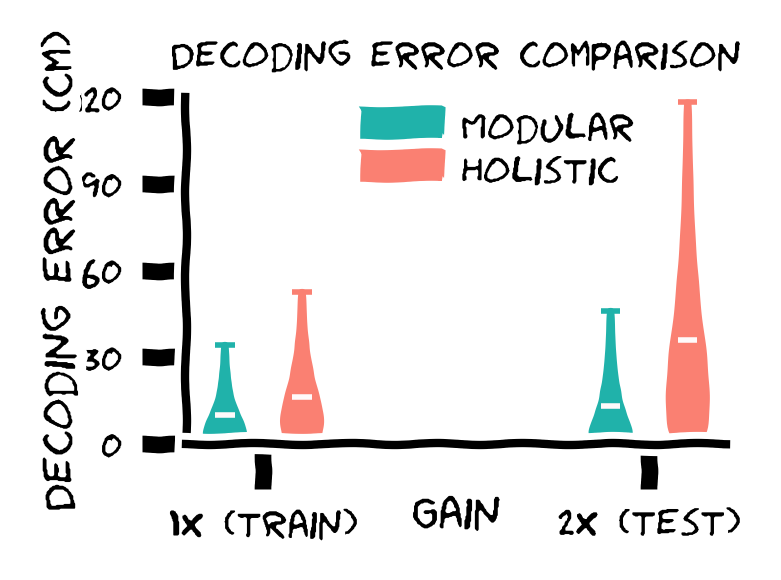

In [60]:
# @title Decoding error comparison

with plt.xkcd():
    xticks = np.array([0, 1]); xticklabels = ['1x (train)', '2x (test)']
    yticks = np.linspace(0, 120, 5)

    fig = plt.figure(figsize=(2.2, 1.7), dpi=200)
    ax = fig.add_subplot(111)
    ax.set_title('Decoding error comparison', fontsize=fontsize, fontweight='bold')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'Gain', fontsize=fontsize + 1)
    ax.set_ylabel('Decoding error (cm)', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0] - 0.2, xticks[-1] + 0.2)
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.15)
    ax.yaxis.set_label_coords(-0.2, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    violin1 = ax.violinplot(filter_fliers([modular_decoding_error, modular_decoding_error_2x]),
                            positions=xticks - 0.1, showmeans=True, widths=0.1)
    set_violin_plot(violin1, facecolor=modular_c, edgecolor=modular_c)

    violin2 = ax.violinplot(filter_fliers([holistic_decoding_error, holistic_decoding_error_2x]),
                            positions=xticks + 0.1, showmeans=True, widths=0.1)
    set_violin_plot(violin2, facecolor=holistic_c, edgecolor=holistic_c)

    ax.legend([violin1['bodies'][0], violin2['bodies'][0]], ['Modular', 'Holistic'],
              fontsize=fontsize, frameon=False, loc=[0.3, 0.7],
              handletextpad=0.5, labelspacing=0.2, ncol=1, columnspacing=1)

    fig.tight_layout(pad=0.1, rect=(0, 0, 1, 1))

While both agents demonstrated small decoding errors with the training gain, we observed that the holistic agent, which struggled with generalization at the $2×$ gain, also exhibited reduced accuracy in determining its own location. This helps explain why the modular agent can generalize better at higher gains.

**Conclusion for the gain task:** In the gain task, the modular agent exhibited better generalization than the holistic agent, supported by a more accurate internal belief when faced with larger gains.

In [61]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_decoding_analysis")

---
# Bonus Section 2: Generalization, but no free lunch

The No Free Lunch theorems proved that no inductive bias can excel across all tasks. It has been studied in the [paper](https://www.science.org/doi/10.1126/sciadv.adk1256) that agents with a modular architecture can acquire the underlying structure of the training task. In contrast, holistic agents tend to acquire different knowledge than modular agents during training, such as forming beliefs based on unreliable information sources or exhibiting less efficient control actions. The novel gain task has a structure similar to the training task, consequently, a modular agent that accurately learns the training task's structure can leverage its knowledge in these novel tasks.

However, it is worth noting that an infinite number of new tasks can be constructed, diverging from the training task's structure but aligning with the 'inferior' beliefs and control acquired by holistic agents.

For example, although we have seen that the holistic agent developed inefficient trajectories with higher curvature, which is detrimental for the training task, if we consider a new task with a different reward function, such as preferring more curved trajectories, the holistic agent should perform better in this particular task than the modular agent. *There is no free lunch*.

In [62]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_generalization_but_no_free_lunch")